In [49]:
import sys
sys.path.append('./scripts')

import pandas as pd
import numpy as np
import os
import re
import ast

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from data_featurization import (load_cif_structure, parse_formula, check_formulas_similar, get_normalized_formula)
from sklearn.decomposition import PCA

from mp_api.client import MPRester

from maml.models import AtomSetsReg

from tqdm.auto import tqdm as tqdm_pandas
import warnings

warnings.filterwarnings("ignore")
tqdm_pandas.pandas()

### Define paths for relevant directories and load dataframes

In [5]:
icsd_database_unlabelled_featurized_path = r".\data\icsd_database_unlabelled_featurized_w_bg.pkl"
mp_database_unlabelled_featurized_path = r".\data\mp_database_featurized.pkl"
labelled_conductivity_database_path = r".\data\ionic_conductivity_database_11022023_wo_duplicates_wclusters.csv"
labelled_conductivity_database_features_path = r".\data\graph_based_features_11022023_wo_duplicates.pkl"
icsd_li_cifs_path = r"C:\Users\mchaf\Desktop\icsd_li_cifs"

In [6]:
icsd_database_unlabelled_featurized = pd.read_pickle(icsd_database_unlabelled_featurized_path)
labelled_conductivity_database = pd.read_csv(labelled_conductivity_database_path)
labelled_conductivity_database_features = pd.read_pickle(labelled_conductivity_database_features_path)

### Calculate distance metric for ICSD compounds

In [4]:
feature = "structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy"

labelled_conductivity_database_features.reset_index(inplace=True)
icsd_database_unlabelled_featurized.reset_index(inplace=True)

features_train = [df.to_numpy() for df in labelled_conductivity_database_features[feature].to_list()]
features_icsd = [df.to_numpy() for df in icsd_database_unlabelled_featurized[feature].to_list()]

features_train_mean = [np.mean(feature_matrix, axis=0) for feature_matrix in features_train]
features_icsd_mean = [np.mean(feature_matrix, axis=0) for feature_matrix in features_icsd]

pca = PCA()
pca.fit(features_train_mean)
features_train_pca = pca.transform(features_train_mean)
variances_train = pca.explained_variance_
centroid_train_pca = np.mean(features_train_pca, axis=0)
squared_diff_train = (features_train_pca - centroid_train_pca)**2
sqrt_variances = np.sqrt(variances_train)
normalized_squared_diff_train = squared_diff_train / sqrt_variances
normalized_distances_train = np.sqrt(np.sum(normalized_squared_diff_train, axis=1))

features_icsd_pca = pca.transform(features_icsd_mean)
squared_diff_icsd = (features_icsd_pca - centroid_train_pca)**2
normalized_squared_diff_icsd = squared_diff_icsd / sqrt_variances
normalized_distances_icsd = np.sqrt(np.sum(normalized_squared_diff_icsd, axis=1))

mean_d_train = np.mean(normalized_distances_train)
normalized_distances_icsd /= mean_d_train

icsd_database_unlabelled_featurized['normalized_distance_to_centroid'] = normalized_distances_icsd

normalized_distances_to_train_icsd = []
for test_point in features_icsd_pca:
    squared_diff_to_train = (features_train_pca - test_point)**2
    normalized_squared_diff_train = squared_diff_to_train / sqrt_variances
    distances_to_train = np.sqrt(np.sum(normalized_squared_diff_train, axis=1))
    
    min_distance = np.min(distances_to_train)
    normalized_distances_to_train_icsd.append(min_distance) 

normalized_distances_to_train_icsd = np.array(normalized_distances_to_train_icsd)
normalized_distances_to_train_icsd /= mean_d_train

icsd_database_unlabelled_featurized['normalized_distance_to_training_point'] = normalized_distances_to_train_icsd

## Predict on ICSD compounds

In [ ]:
feature = "structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy"
model_ensemble_filepath = r".\data\final_models_camns_level1_n1_pr_auc_nepochs183_screening"
summary_filename = "icsd_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening"
icsd_database_unlabelled_featurized.dropna(subset=[feature], inplace=True)
icsd_database_unlabelled_featurized.reset_index(drop=True, inplace=True)
model_columns = []
predictions_list = []
for i, model_name in enumerate(os.listdir(model_ensemble_filepath)):
    print(f"Getting predictions for model {i}: {model_name}")
    model_path = os.path.join(model_ensemble_filepath, model_name, "model")
    model = AtomSetsReg.from_dir(model_path)
    pred = model._predict(icsd_database_unlabelled_featurized[feature].to_list())
    predictions_list.append(pred)
    model_columns.append(model_name + "_prediction")

In [20]:
icsd_predictions_df = pd.DataFrame(np.concatenate(predictions_list, axis=1), columns=model_columns)
icsd_predictions_df['prediction_mean'] = icsd_predictions_df[model_columns].mean(axis=1)
icsd_predictions_df['prediction_std'] = icsd_predictions_df[model_columns].std(axis=1)

icsd_predictions_df = pd.concat([icsd_database_unlabelled_featurized, icsd_predictions_df], axis=1)
icsd_predictions_df['predicted_is_superionic'] = icsd_predictions_df['prediction_mean'].apply(lambda x: 1 if x >= 0.5 else 0)

icsd_predictions_summary = icsd_predictions_df[['id_num', 'icsd_collectioncode', 'temperature', 'pressure', 'prediction_mean', 'prediction_std',
       'predicted_is_superionic', 'band_gap_mp', 'band_gap_prediction_megnet', 'normalized_formula', 'formula', 'normalized_distance_to_centroid', 'normalized_distance_to_training_point']]
icsd_predictions_summary.sort_values(by='prediction_mean', ascending=False, inplace=True)
icsd_predictions_summary.to_csv(f".\data\{summary_filename}.csv", index=False)

### Apply filters to remove known conductors and metallic compounds

In [6]:
summary_filename = "icsd_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening"
icsd_predictions_summary = pd.read_csv(f".\data\{summary_filename}.csv")
icsd_predictions_summary['parsed_normalized_formula'] = icsd_predictions_summary['normalized_formula'].progress_apply(parse_formula)
labelled_conductivity_database['parsed_normalized_formula'] = labelled_conductivity_database['normalized_formula'].progress_apply(parse_formula)

  0%|          | 0/10714 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

In [9]:
known_conductors = []
for idx, row in icsd_predictions_summary.iterrows():
    for idy, label_row in labelled_conductivity_database.iterrows():
        if check_formulas_similar(row['parsed_normalized_formula'], label_row['parsed_normalized_formula'], tolerance=0.1):
            known_conductors.append(idx)
            break

icsd_predictions_summary_filtered = icsd_predictions_summary.drop(known_conductors)
filtered_summary_filename = summary_filename + "_filtered"
#icsd_predictions_summary_filtered.to_csv(f".\data\{filtered_summary_filename}.csv", index=False)

In [10]:
# Check if band gap is less than 1 or 2 eV
for band_gap_threshold in [1, 2]:
    filter_band_gap_mp = icsd_predictions_summary['band_gap_mp'].notnull() & (icsd_predictions_summary['band_gap_mp'] >= band_gap_threshold)
    filter_band_gap_prediction_megnet = icsd_predictions_summary['band_gap_mp'].isnull() & icsd_predictions_summary['band_gap_prediction_megnet'].notnull() & (icsd_predictions_summary['band_gap_prediction_megnet'] >= band_gap_threshold)
    final_filter = filter_band_gap_mp | filter_band_gap_prediction_megnet
    icsd_predictions_summary_bg = icsd_predictions_summary[final_filter]
    summary_filename_bg = summary_filename + f"_{band_gap_threshold}eVbandgap"
    icsd_predictions_summary_bg.to_csv(f".\data\{summary_filename_bg}.csv", index=False)

for band_gap_threshold in [1, 2]:
    filter_band_gap_mp = icsd_predictions_summary_filtered['band_gap_mp'].notnull() & (icsd_predictions_summary_filtered['band_gap_mp'] >= band_gap_threshold)
    filter_band_gap_prediction_megnet = icsd_predictions_summary_filtered['band_gap_mp'].isnull() & icsd_predictions_summary_filtered['band_gap_prediction_megnet'].notnull() & (icsd_predictions_summary_filtered['band_gap_prediction_megnet'] >= band_gap_threshold)
    final_filter = filter_band_gap_mp | filter_band_gap_prediction_megnet
    icsd_predictions_summary_filtered_bg = icsd_predictions_summary_filtered[final_filter]
    summary_filename_bg = filtered_summary_filename + f"_{band_gap_threshold}eVbandgap"
    icsd_predictions_summary_filtered_bg.to_csv(f".\data\{summary_filename_bg}.csv", index=False)

### Plot summary

In [11]:
icsd_predictions_summary_1eVbandgap = pd.read_csv(f".\data\icsd_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening_1eVbandgap.csv")
icsd_predictions_summary_1eVbandgap['structure'] = icsd_predictions_summary_1eVbandgap['icsd_collectioncode'].progress_apply(load_cif_structure, cif_dir=icsd_li_cifs_path)
icsd_predictions_summary_1eVbandgap['ordered'] = [struc.is_ordered for struc in icsd_predictions_summary_1eVbandgap['structure'].to_list()]

  0%|          | 0/6863 [00:00<?, ?it/s]

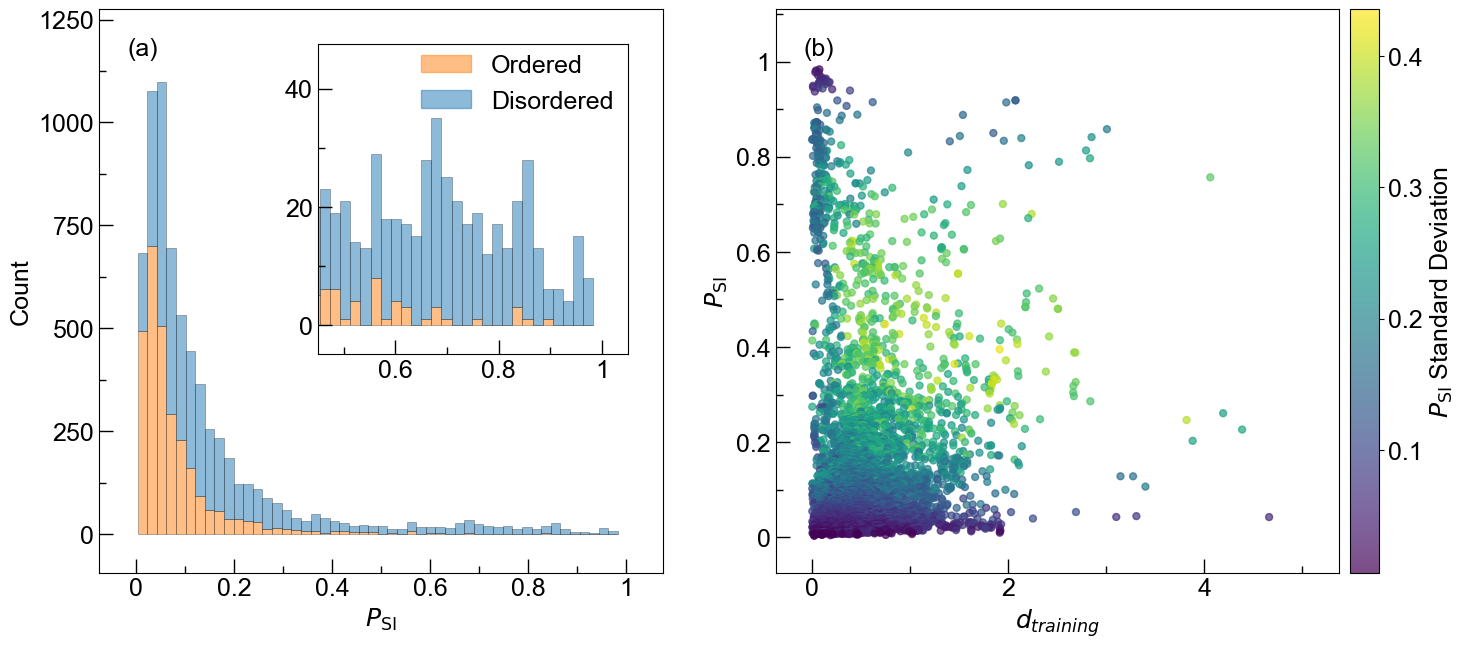

In [19]:
plt.rcParams['font.family'] = 'Arial'

# Create a figure with constrained layout
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.2)

# First subplot with stacked histogram and inset
ax1 = fig.add_subplot(gs[0])
color_disordered = "tab:blue"
color_ordered = "tab:orange"

# Filter data for ordered and disordered categories
ordered_data = icsd_predictions_summary_1eVbandgap[icsd_predictions_summary_1eVbandgap['ordered'] == True]
disordered_data = icsd_predictions_summary_1eVbandgap[icsd_predictions_summary_1eVbandgap['ordered'] == False]

# Create the stacked histogram
n, bins, patches = ax1.hist([ordered_data['prediction_mean'], disordered_data['prediction_mean']], 
         bins=50, stacked=True, color=[color_ordered, color_disordered], edgecolor='k', linewidth=0.4, alpha=0.5)



ax1.set_xlim(-0.075, 1.075)
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=18)

ax1.set_ylim(-93.75, 1275)
ax1.set_yticks([0, 250, 500, 750, 1000, 1250])
ax1.set_yticklabels([0, 250, 500, 750, 1000, 1250], fontsize=18)
ax1.tick_params(axis='both', which='major', direction='in', length=10, width=1, colors='k')
ax1.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(125))

ax1.set_xlabel('$P_{\mathrm{SI}}$', fontsize=18)
ax1.set_ylabel('Count', fontsize=18)

ax1.set_aspect(np.diff(ax1.get_xlim()) / np.diff(ax1.get_ylim()))
ax1.text(0.05, 0.95, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)

ax_inset = inset_axes(ax1, width="100%", height="100%", loc='upper right', 
                      bbox_to_anchor=(0.4, 0.4, 0.55, 0.55), bbox_transform=ax1.transAxes)
ax_inset.hist([ordered_data['prediction_mean'], disordered_data['prediction_mean']], 
              bins=50, stacked=True, color=[color_ordered, color_disordered], edgecolor='k', linewidth=0.4, alpha=0.5)

ax_inset.set_xlim(0.45, 1.05)
ax_inset.set_ylim(-5, 47.5)
ax_inset.set_xticks([0.6, 0.8, 1])
ax_inset.set_xticklabels([0.6, 0.8, 1], fontsize=18)
ax_inset.set_yticks([0, 20, 40])
ax_inset.set_yticklabels([0, 20, 40], fontsize=18)
ax_inset.tick_params(axis='both', which='major', direction='in', length=10, width=1, colors='k')
ax_inset.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
ax_inset.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_inset.yaxis.set_minor_locator(ticker.MultipleLocator(10))

# Format y-axis tick labels to remove decimals
ax_inset.set_yticklabels(ax_inset.get_yticks(), fontsize=18)
ax_inset.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}'))

# Second subplot for scatter plot
ax2 = fig.add_subplot(gs[1])
ax2.text(0.05, 0.95, '(b)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes)
normalized_distance = icsd_predictions_summary_1eVbandgap['normalized_distance_to_training_point']
prediction_mean = icsd_predictions_summary_1eVbandgap['prediction_mean']
prediction_std = icsd_predictions_summary_1eVbandgap['prediction_std']

scatter = ax2.scatter(x=normalized_distance, y=prediction_mean, c=prediction_std, cmap='viridis', alpha=0.7, edgecolor=None, s=25)

ax2.set_xlim([0, 5])
ax2.set_xlabel('$d_{training}$', fontsize=18)
ax2.set_ylabel('$P_{\mathrm{SI}}$', fontsize=18)
ax2.set_xticks([0, 2, 4])
ax2.set_xticklabels([0, 2, 4], fontsize=18)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=18)
ax2.set_ylim([-0.075, 1.11])
ax2.set_xlim([-0.375, 5.375])
ax2.set_aspect(np.diff(ax2.get_xlim()) / np.diff(ax2.get_ylim()))
ax2.tick_params(axis='both', which='major', direction='in', length=10, width=1, colors='k')
ax2.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

# Add colorbar
cax = ax2.inset_axes([1.02, 0, 0.05, 1])
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('$P_{\mathrm{SI}}$ Standard Deviation', fontsize=18)
cbar.ax.tick_params(labelsize=18)
tick_locator = plt.MaxNLocator(nbins=5)  # Set the number of bins
cbar.locator = tick_locator
cbar.update_ticks()

legend_patches = [Patch(color=color_ordered, label='Ordered', alpha=0.5), Patch(color=color_disordered, label='Disordered', alpha=0.5)]
ax_inset.legend(handles=legend_patches, bbox_to_anchor=(0.3, 1), loc='upper left', borderaxespad=0., fontsize=18, frameon=False)

plt.savefig('icsd_histogram_and_probdistance.png', dpi=1200, bbox_inches='tight')
plt.show()

## Predict on Materials Project compounds

In [17]:
mp_database_unlabelled_featurized = pd.read_pickle(mp_database_unlabelled_featurized_path)

### Calculate distance metric for Material Project compounds

In [18]:
feature = "structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy"

mp_database_unlabelled_featurized.reset_index(inplace=True)
features_mp = [df.to_numpy() for df in mp_database_unlabelled_featurized[feature].to_list()]
features_mp_mean = [np.mean(feature_matrix, axis=0) for feature_matrix in features_mp]

labelled_conductivity_database_features.reset_index(inplace=True)
features_train = [df.to_numpy() for df in labelled_conductivity_database_features[feature].to_list()]
features_train_mean = [np.mean(feature_matrix, axis=0) for feature_matrix in features_train]

pca = PCA()
pca.fit(features_train_mean)
features_train_pca = pca.transform(features_train_mean)
variances_train = pca.explained_variance_
centroid_train_pca = np.mean(features_train_pca, axis=0)
squared_diff_train = (features_train_pca - centroid_train_pca)**2
sqrt_variances = np.sqrt(variances_train)
normalized_squared_diff_train = squared_diff_train / sqrt_variances
normalized_distances_train = np.sqrt(np.sum(normalized_squared_diff_train, axis=1))

features_mp_pca = pca.transform(features_mp_mean)
squared_diff_mp = (features_mp_pca - centroid_train_pca)**2
normalized_squared_diff_mp = squared_diff_mp / sqrt_variances
normalized_distances_mp = np.sqrt(np.sum(normalized_squared_diff_mp, axis=1))

mean_d_train = np.mean(normalized_distances_train)
normalized_distances_mp /= mean_d_train

mp_database_unlabelled_featurized['normalized_distance_to_centroid'] = normalized_distances_mp

normalized_distances_to_train_mp = []
for test_point in features_mp_pca:
    squared_diff_to_train = (features_train_pca - test_point)**2
    normalized_squared_diff_train = squared_diff_to_train / sqrt_variances
    distances_to_train = np.sqrt(np.sum(normalized_squared_diff_train, axis=1))

    min_distance = np.min(distances_to_train)
    normalized_distances_to_train_mp.append(min_distance) 

normalized_distances_to_train_mp = np.array(normalized_distances_to_train_mp)
normalized_distances_to_train_mp /= mean_d_train

mp_database_unlabelled_featurized['normalized_distance_to_training_point'] = normalized_distances_to_train_mp

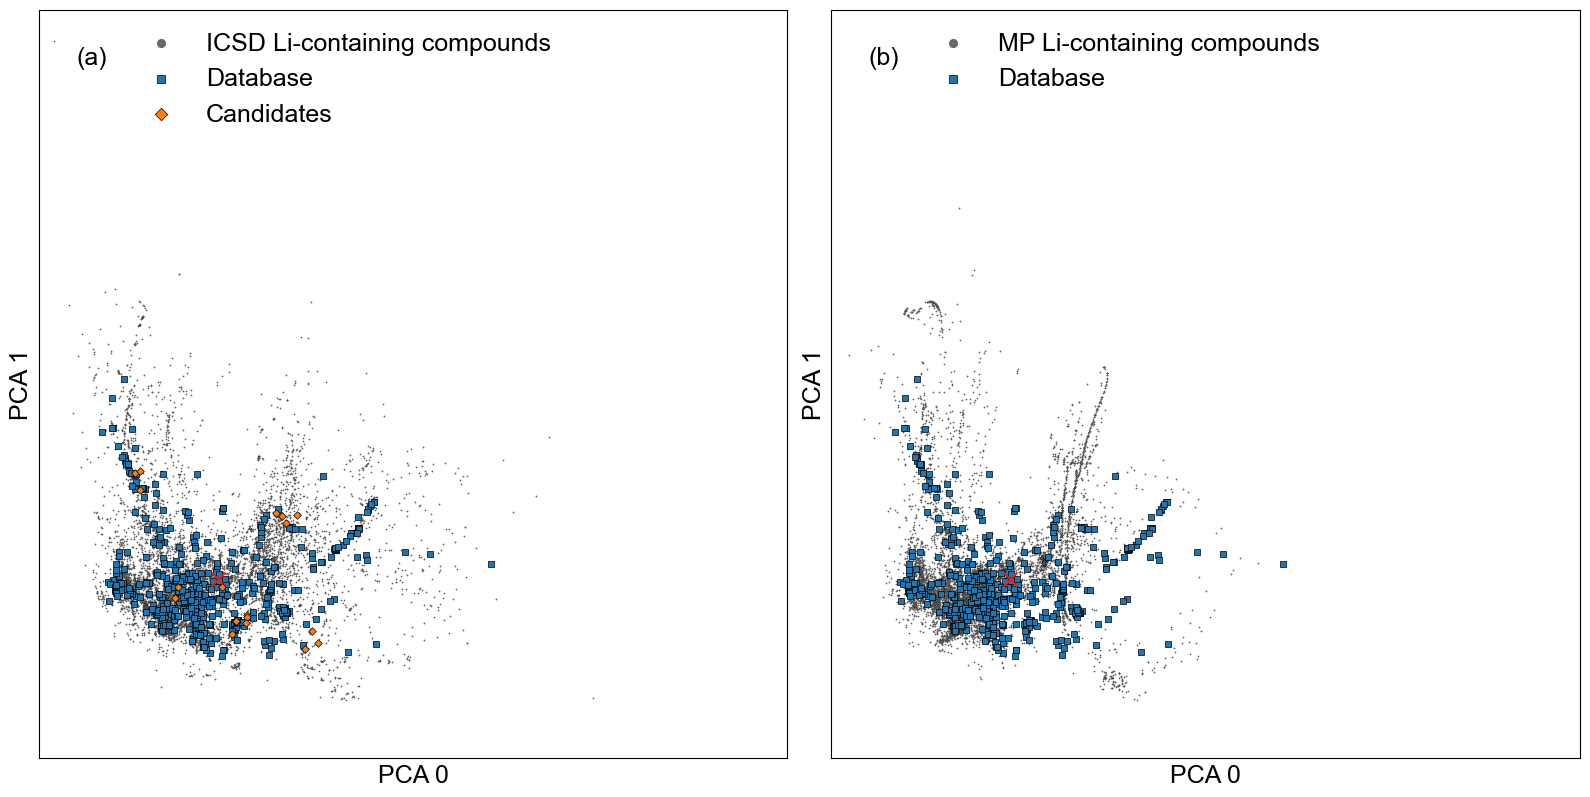

In [35]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.rcParams['font.family'] = 'Arial'
plt.xlabel('PCA 0', fontsize=18)
plt.ylabel('PCA 1', fontsize=18)
plt.text(0.05, 0.95, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes)
plt.ylim([-2.75, 8.75])
plt.xlim([-2.75, 8.75])
plt.gca().set_aspect(np.diff(plt.gca().get_xlim()) / np.diff(plt.gca().get_ylim()))

plt.scatter(features_icsd_pca[:, 0], features_icsd_pca[:, 1], label='ICSD Li-containing compounds', edgecolor='black', color='dimgray', linewidth=0.1, marker='o', alpha=1, s=1)
plt.scatter(features_train_pca[:, 0], features_train_pca[:, 1], label='Database', edgecolor='black', color="tab:blue", linewidth=0.5, marker='s', alpha=1, s=15)
plt.scatter(centroid_train_pca[0], centroid_train_pca[1], label='', color='tab:red', marker='x', s=100)

candidate_icsds = [98583, 71146, 48716, 23620, 143927, 63870, 430602, 23621, 428102, 412654, 425643, 45740, 73151, 42738, 642338, 256678, 27177, 196425, 642202, 45741]
features_candidates = icsd_database_unlabelled_featurized[icsd_database_unlabelled_featurized['icsd_collectioncode'].isin(candidate_icsds)][feature].to_list()
features_candidates_mean = []
for feature_matrix in features_candidates:
    aggregated_feature = np.mean(feature_matrix, axis=0)
    features_candidates_mean.append(aggregated_feature)
features_candidates_pca = pca.transform(features_candidates_mean)

plt.scatter(features_candidates_pca[:, 0], features_candidates_pca[:, 1], label='Candidates', edgecolor='black', color="tab:orange", linewidth=0.5, marker='D', alpha=1, s=15)

plt.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k')
plt.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
plt.xticks([])
plt.yticks([])

legend = plt.gca().legend(loc='upper left', bbox_to_anchor=(0.1, 1), fontsize=18, frameon=False)
for legend_handle in legend.legendHandles:
    legend_handle.set_sizes([40])


plt.subplot(1, 2, 2)
plt.rcParams['font.family'] = 'Arial'
plt.xlabel('PCA 0', fontsize=18)
plt.ylabel('PCA 1', fontsize=18)
plt.text(0.05, 0.95, '(b)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes)
plt.ylim([-2.75, 8.75])
plt.xlim([-2.75, 8.75])
plt.gca().set_aspect(np.diff(plt.gca().get_xlim()) / np.diff(plt.gca().get_ylim()))

plt.scatter(features_mp_pca[:, 0], features_mp_pca[:, 1], label='MP Li-containing compounds', edgecolor='black', color='dimgray', linewidth=0.1, marker='o', alpha=1, s=1)
plt.scatter(features_train_pca[:, 0], features_train_pca[:, 1], label='Database', edgecolor='black', color="tab:blue", linewidth=0.5, marker='s', alpha=1, s=15)
plt.scatter(centroid_train_pca[0], centroid_train_pca[1], label='', color='tab:red', marker='x', s=100)

plt.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k')
plt.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
plt.xticks([])
plt.yticks([])

legend = plt.gca().legend(loc='upper left', bbox_to_anchor=(0.1, 1), fontsize=18, frameon=False)
for legend_handle in legend.legendHandles:
    legend_handle.set_sizes([40])

plt.tight_layout()
plt.savefig('icsd_and_mp_embedding.png', dpi=600)
plt.show()

In [9]:
feature = "structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy"
model_ensemble_filepath = r".\data\final_models_camns_level1_n1_pr_auc_nepochs183_screening"
summary_filename = "mp_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening"
mp_database_unlabelled_featurized.dropna(subset=[feature], inplace=True)
mp_database_unlabelled_featurized.reset_index(drop=True, inplace=True)
print(len(mp_database_unlabelled_featurized))
model_columns = []
predictions_list = []
for i, model_name in enumerate(os.listdir(model_ensemble_filepath)):
    print(f"Getting predictions for model {i}: {model_name}")
    model_path = os.path.join(model_ensemble_filepath, model_name, "model")
    model = AtomSetsReg.from_dir(model_path)
    pred = model._predict(mp_database_unlabelled_featurized[feature].to_list())
    predictions_list.append(pred)
    model_columns.append(model_name + "_prediction")

12555
Getting predictions for model 0: 22b92b47_run_1
1/1 [==============================] - 0s 42ms/step
Getting predictions for model 1: 22b92b47_run_10
1/1 [==============================] - 0s 30ms/step
Getting predictions for model 2: 22b92b47_run_2
1/1 [==============================] - 0s 30ms/step
Getting predictions for model 3: 22b92b47_run_3
1/1 [==============================] - 0s 29ms/step
Getting predictions for model 4: 22b92b47_run_4
1/1 [==============================] - 0s 29ms/step
Getting predictions for model 5: 22b92b47_run_5
1/1 [==============================] - 0s 30ms/step
Getting predictions for model 6: 22b92b47_run_6
1/1 [==============================] - 0s 30ms/step
Getting predictions for model 7: 22b92b47_run_7
1/1 [==============================] - 0s 29ms/step
Getting predictions for model 8: 22b92b47_run_8
1/1 [==============================] - 0s 29ms/step
Getting predictions for model 9: 22b92b47_run_9
1/1 [==============================] - 0s 29m

In [21]:
mp_predictions_df = pd.DataFrame(np.concatenate(predictions_list, axis=1), columns=model_columns)
mp_predictions_df['prediction_mean'] = mp_predictions_df[model_columns].mean(axis=1)
mp_predictions_df['prediction_std'] = mp_predictions_df[model_columns].std(axis=1)
mp_predictions_df['predicted_is_superionic'] = mp_predictions_df['prediction_mean'].apply(lambda x: 1 if x >= 0.5 else 0)

mp_predictions_df = pd.concat([mp_database_unlabelled_featurized, mp_predictions_df], axis=1)

mp_predictions_summary = mp_predictions_df[['material_id', 'formula_pretty', 'formula', 
                                            'database_IDs', 'energy_above_hull', 'theoretical', 
                                            'band_gap', 'prediction_mean', 'prediction_std',
                                            'predicted_is_superionic', 'normalized_distance_to_centroid', 
                                            'normalized_distance_to_training_point']]
mp_predictions_summary.rename(columns={"band_gap": "band_gap_mp", "material_id": "mp_id"}, inplace=True)
mp_predictions_summary.sort_values(by='prediction_mean', ascending=False, inplace=True)
mp_predictions_summary.to_csv(f".\data\{summary_filename}.csv", index=False)
filtered_summary_filename = summary_filename + "_filtered"
for band_gap_threshold in [1, 2]:
    mp_predictions_summary_filtered = mp_predictions_summary[mp_predictions_summary['band_gap_mp'] >= band_gap_threshold]
    summary_filename_bg = filtered_summary_filename + f"_{band_gap_threshold}eVbandgap"
    mp_predictions_summary_filtered.to_csv(f".\data\{summary_filename_bg}.csv", index=False)

### Compare Materials Project and ICSD predictions

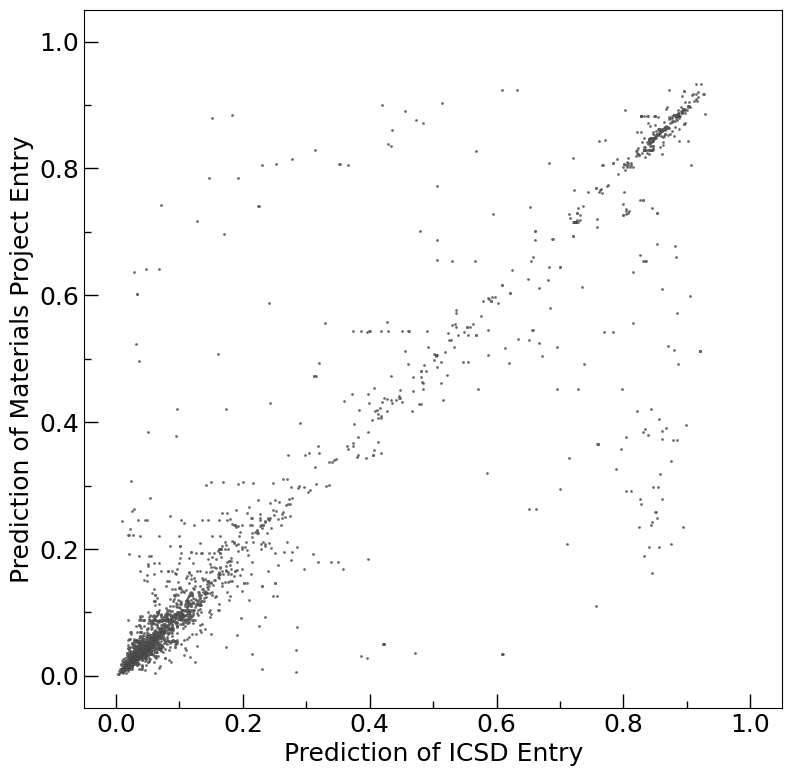

In [27]:
icsd_df = pd.read_csv('.\data\icsd_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening.csv')
mp_df = pd.read_csv('.\data\mp_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening.csv')

icsd_df_relevant = icsd_df[['icsd_collectioncode', 'prediction_mean']]
mp_df_relevant = mp_df[['mp_id', 'database_IDs', 'prediction_mean']]

def extract_icsd_codes(database_ids):
    try:
        ids_dict = ast.literal_eval(database_ids)
        if 'icsd' in ids_dict:
            return [int(code.split('-')[1]) for code in ids_dict['icsd']]
    except (ValueError, SyntaxError, KeyError, TypeError):
        return []
    return []

mp_df_relevant['icsd_codes'] = mp_df_relevant['database_IDs'].apply(extract_icsd_codes)
mp_df_flat = mp_df_relevant.explode('icsd_codes').dropna(subset=['icsd_codes'])

merged_df = pd.merge(icsd_df_relevant, mp_df_flat, left_on='icsd_collectioncode', right_on='icsd_codes', suffixes=('_icsd', '_mp'))

comparison_df = merged_df[['icsd_collectioncode', 'prediction_mean_icsd', 'mp_id', 'prediction_mean_mp']]
comparison_df['prediction_diff'] = abs(comparison_df['prediction_mean_icsd'] - comparison_df['prediction_mean_mp']) 

fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams['font.family'] = 'Arial'
plt.xlabel('Prediction of ICSD Entry', fontsize=18)
plt.ylabel('Prediction of Materials Project Entry', fontsize=18)
sc = ax.scatter(comparison_df['prediction_mean_icsd'], 
                comparison_df['prediction_mean_mp'], edgecolor='black', color='dimgray', linewidth=0.1, marker='o', alpha=1, s=3)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k')
plt.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.gca().set_aspect(np.diff(plt.gca().get_xlim()) / np.diff(plt.gca().get_ylim()))

plt.tight_layout()
plt.savefig('prediction_difference.png', dpi=600)
plt.show()

### Create final .csv files of predictions

In [63]:
icsd_df = pd.read_csv('./data/icsd_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening.csv')
mp_df = pd.read_csv('./data/mp_predictions_summary_camns_level1_2_pr_auc_nepochs183_screening.csv')

def extract_icsd_codes(database_ids):
    try:
        ids_dict = ast.literal_eval(database_ids)
        if 'icsd' in ids_dict:
            return [int(code.split('-')[1]) for code in ids_dict['icsd']]
    except (ValueError, SyntaxError, KeyError, TypeError):
        return []
    return []

mp_df['icsd_ids'] = mp_df['database_IDs'].apply(extract_icsd_codes)

mp_exploded_df = mp_df.explode('icsd_ids')

merged_df = pd.merge(
    icsd_df, 
    mp_exploded_df, 
    left_on='icsd_collectioncode', 
    right_on='icsd_ids', 
    how='outer', 
    suffixes=('_icsd', '_mp')
)

column_order = ['icsd_collectioncode', 'mp_id', 'formula_icsd', 
                'formula_mp', 'prediction_mean_icsd', 'prediction_std_icsd',
               'predicted_is_superionic_icsd', 'prediction_mean_mp', 'prediction_std_mp',
               'predicted_is_superionic_mp', 'band_gap_mp_icsd', 'band_gap_mp_mp', 'band_gap_prediction_megnet', 
                'energy_above_hull', 'normalized_distance_to_training_point_icsd', 'normalized_distance_to_centroid_icsd', 
               'normalized_distance_to_training_point_mp', 'normalized_distance_to_centroid_mp', 'temperature',
               'pressure', 'theoretical', 'database_IDs', 'normalized_formula']

merged_df.drop(columns=['id_num', 'formula_pretty', 'icsd_ids'], inplace=True)
merged_df = merged_df[column_order]
merged_df['sort_prediction_mean'] = merged_df['prediction_mean_icsd'].fillna(merged_df['prediction_mean_mp'])
merged_df = merged_df.sort_values(by='sort_prediction_mean', ascending=False)

merged_df.drop(columns=['sort_prediction_mean'], inplace=True)

In [64]:
with MPRester("4d2ZmV61lAUP1Ghz5x1MilPhUG6dMyst") as mpr:
    docs = mpr.summary.search(elements=["Li"], fields=['material_id', 'structure'])
docs = [dict(i) for i in docs]
mp_structure_df = pd.DataFrame(docs)

mp_structure_df['normalized_formula'] = mp_structure_df['structure'].progress_apply(get_normalized_formula)
mp_structure_df.rename(columns={"material_id": "mp_id"}, inplace=True)

merged_df = pd.merge(
    merged_df,
    mp_structure_df[['mp_id', 'normalized_formula']],
    left_on='mp_id',
    right_on='mp_id',
    how='left',
    suffixes=('', '_new')
)

merged_df['normalized_formula'] = merged_df['normalized_formula'].fillna(merged_df['normalized_formula_new'])
merged_df.drop(columns=['normalized_formula_new'], inplace=True)

Retrieving SummaryDoc documents:   0%|          | 0/21686 [00:00<?, ?it/s]

  0%|          | 0/21686 [00:00<?, ?it/s]

In [65]:
labelled_conductivity_database = pd.read_csv(labelled_conductivity_database_path)
merged_df['parsed_normalized_formula'] = merged_df['normalized_formula'].progress_apply(parse_formula)
labelled_conductivity_database['parsed_normalized_formula'] = labelled_conductivity_database['normalized_formula'].progress_apply(parse_formula)

known_conductors = []
for idx, row in merged_df.iterrows():
    for idy, label_row in labelled_conductivity_database.iterrows():
        if check_formulas_similar(row['parsed_normalized_formula'], label_row['parsed_normalized_formula'], tolerance=0.05):
            known_conductors.append(idx)
            break

merged_df_filtered = merged_df.drop(known_conductors)

  0%|          | 0/21797 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

In [66]:
merged_df['band_gap_priority'] = merged_df['band_gap_mp_icsd'].fillna(
    merged_df['band_gap_mp_mp'].fillna(merged_df['band_gap_prediction_megnet'])
)

merged_df_filtered['band_gap_priority'] = merged_df_filtered['band_gap_mp_icsd'].fillna(
    merged_df_filtered['band_gap_mp_mp'].fillna(merged_df_filtered['band_gap_prediction_megnet'])
)

merged_df = merged_df.fillna('NA')
merged_df_filtered = merged_df_filtered.fillna('NA')

merged_df.to_csv('./data/icsd_and_materialsproject_predictions_sorted.csv', index=False)
merged_df_filtered.to_csv('./data/icsd_and_materialsproject_predictions_sorted_filtered.csv', index=False)

band_gap_threshold = 1
bg_df = merged_df[merged_df['band_gap_priority'] >= band_gap_threshold]
bg_df.drop(columns=['band_gap_priority'], inplace=True)
bg_df.to_csv('./data/icsd_and_materialsproject_predictions_1eV.csv', index=False)

bg_filtered_df = merged_df_filtered[merged_df_filtered['band_gap_priority'] >= band_gap_threshold]
bg_filtered_df.drop(columns=['band_gap_priority'], inplace=True)
bg_filtered_df.to_csv('./data/icsd_and_materialsproject_predictions_sorted_filtered_1eV.csv', index=False)

TypeError: '>=' not supported between instances of 'str' and 'int'